# AdEase Time Series- Web Traffic Time Series Forecasting

- **Ad Ease wants to optimize ad placements for their clients by analyzing page view reports for Wikipedia pages over 550 days, using data from 145,000 pages. Aim is to forecast view counts and understand ad performance across different languages and regions to effectively target their clients' audiences.**

**Concept Used:**

   - Exploratory data analysis

   - Time Series forecasting- ARIMA, SARIMAX, and Prophet
   
   
**Two csv files are provided:**
- train_1.csv contains data on article visits, with rows representing articles and columns representing dates. 
    The page name contains data in this format:
    
              SPECIFIC NAME _ LANGUAGE.wikipedia.org _ ACCESS TYPE _ ACCESS ORIGIN
    
- Exog_Campaign_eng holds data for English pages with a binary indicator (1 for dates with campaigns, 0 otherwise) for days with significant events.This file serves as an exogenous variable for English page models during training and forecasting.

In [61]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from prophet import Prophet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

import re

In [2]:
data = pd.read_csv("train_1.csv")

In [3]:
print(f"Number of rows: {data.shape[0]}\nNumber of columns: {data.shape[1]}")

Number of rows: 145063
Number of columns: 551


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 551 entries, Page to 2016-12-31
dtypes: float64(550), object(1)
memory usage: 609.8+ MB


In [5]:
data.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [6]:
data.columns

Index(['Page', '2015-07-01', '2015-07-02', '2015-07-03', '2015-07-04',
       '2015-07-05', '2015-07-06', '2015-07-07', '2015-07-08', '2015-07-09',
       ...
       '2016-12-22', '2016-12-23', '2016-12-24', '2016-12-25', '2016-12-26',
       '2016-12-27', '2016-12-28', '2016-12-29', '2016-12-30', '2016-12-31'],
      dtype='object', length=551)

In [7]:
# loading exog file
exog= pd.read_csv("Exog_Campaign_eng")

In [8]:
exog.head()

,Exog
0,0
1,0
2,0
3,0
4,0


In [9]:
data.isna().sum()

Page              0
2015-07-01    20740
2015-07-02    20816
2015-07-03    20544
2015-07-04    20654
              ...  
2016-12-27     3701
2016-12-28     3822
2016-12-29     3826
2016-12-30     3635
2016-12-31     3465
Length: 551, dtype: int64

- As we can see there are null value present in df
- for better understanding plotting the null values days vs number_of_null_values

In [10]:
days= [i for i in range(1, len(data.columns))]

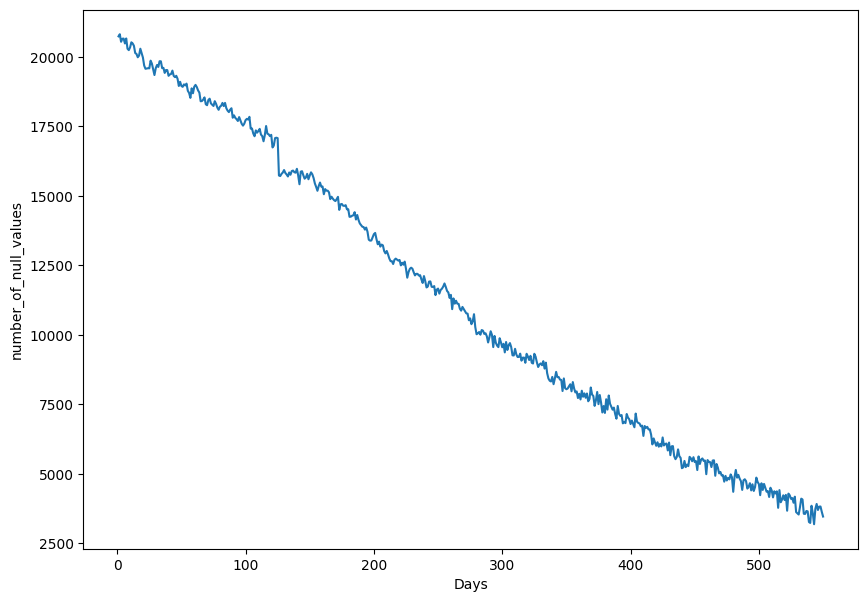

In [11]:
plt.figure(figsize=(10,7))
sns.lineplot(x= days, y= data.isna().sum()[1:])
plt.xlabel("Days")
plt.ylabel("number_of_null_values")
plt.show()

- Over time, we observe a decrease in the number of NaN values.

- **Some websites initially have all NaN values, possibly because they were created after that period, resulting in no traffic data being available for that time.**

In [12]:
print(data.shape)
data=data.dropna(how='all')
#‘all’ : If all values are NA, drop that row or column.
print(data.shape)

data=data.dropna(thresh=300)
print(data.shape)


(145063, 551)
(145063, 551)
(133617, 551)


- We attempt to remove rows where all values are NaN, although none meet this criteria in our dataset.

- Subsequently, we exclude rows with NaN values spanning over 300 days, as the resulting time series would lack meaningful context.

- Finally, we impute all remaining NaN values with zeros under the assumption that these instances correspond to dates without recorded traffic.

In [13]:
data=data.fillna(0)
data.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
5,5566_zh.wikipedia.org_all-access_spider,12.0,7.0,4.0,5.0,20.0,8.0,5.0,17.0,24.0,...,16.0,27.0,8.0,17.0,32.0,19.0,23.0,17.0,17.0,50.0


### Page values are in below formate

**SPECIFIC NAME _ LANGUAGE.britanica.org _ ACCESS TYPE _ ACCESS ORIGIN**

- having information about page name, the main domain, device type used to access the page, and also the request origin(spider or browser agent)

#### Feature extraction

In [14]:
#Function to Extract Language from Page using Regex
def get_language(name):
    if len(re.findall(r'_(.{2}).wikipedia.org_', name)) == 1 : 
        return re.findall(r'_(.{2}).wikipedia.org_', name)[0]
    else: return 'Unknown_language'

data['language'] = data['Page'].apply(get_language)


language_dict ={'de':'German',
                'en':'English', 
                'es': 'Spanish', 
                'fr': 'French', 
                'ja': 'Japenese' , 
                'ru': 'Russian', 
                'zh': 'Chinese',
                'Unknown_language': 'Unknown_lang'}

data['language'] = data['language'].map(language_dict)

In [15]:
# Access_type
def get_access_type(name):
    if len(re.findall(r'all-access|mobile-web|desktop', name)) == 1 : 
        return re.findall(r'all-access|mobile-web|desktop', name)[0]
    else: return 'No Access_type'

data['access_type'] = data['Page'].apply(get_access_type)

In [16]:
def get_access_origin(name):
    if len(re.findall(r'[ai].org_(.*)_(.*)$', name)) == 1 : 
        return re.findall(r'[ai].org_(.*)_(.*)$', name)[0][1]
    else: return 'No Access_origin'
    
data['access_origin'] = data['Page'].apply(get_access_origin)

In [17]:
data.isna().sum()

Page             0
2015-07-01       0
2015-07-02       0
2015-07-03       0
2015-07-04       0
                ..
2016-12-30       0
2016-12-31       0
language         0
access_type      0
access_origin    0
Length: 554, dtype: int64

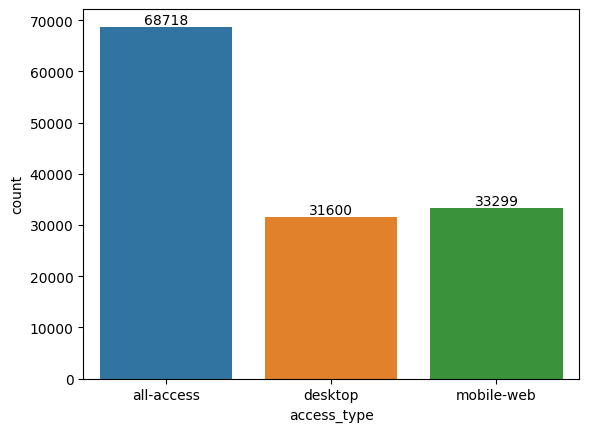

In [18]:
label= sns.countplot(data=data, x="access_type")
for i in label.containers:
  label.bar_label(i)
plt.show()

- In above plot desktop and mobile access have almost same usage.

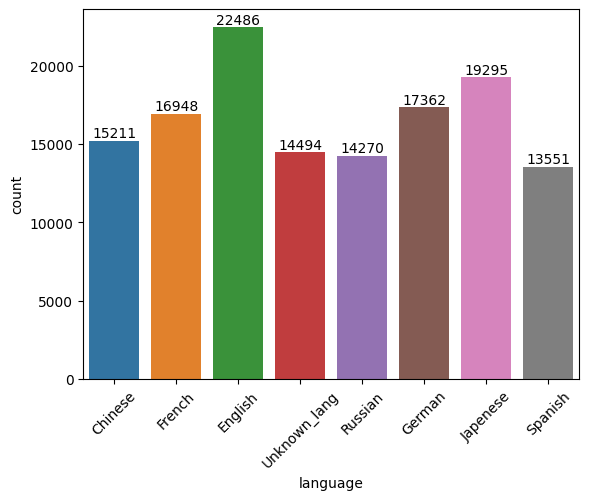

In [19]:

lb= sns.countplot(data=data, x="language")
for i in lb.containers:
  lb.bar_label(i)
plt.xticks(rotation=45)
plt.show()

- From above plot "English" language has most number of articles

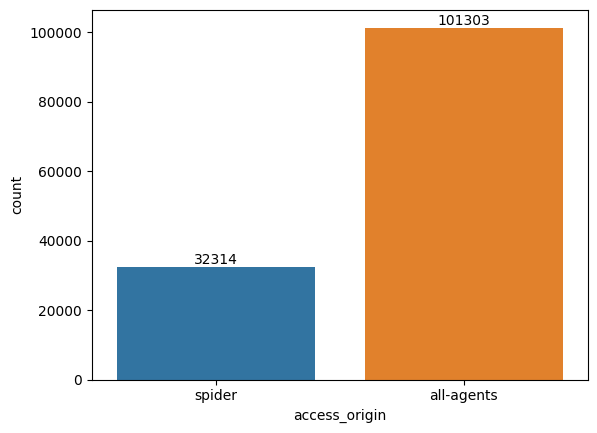

In [20]:
lbl= sns.countplot(data=data, x= "access_origin")
for i in lbl.containers:
  lbl.bar_label(i)

- In above plot it shows that organic views is far more than spiders.

### Reshaping data

In [21]:
reshaped = data.melt(id_vars = ['Page','language','access_type','access_origin'], var_name="Date", value_name="Visits")

In [22]:
reshaped.head()

,Page,language,access_type,access_origin,Date,Visits
0,2NE1_zh.wikipedia.org_all-access_spider,Chinese,all-access,spider,2015-07-01,18.0
1,2PM_zh.wikipedia.org_all-access_spider,Chinese,all-access,spider,2015-07-01,11.0
2,3C_zh.wikipedia.org_all-access_spider,Chinese,all-access,spider,2015-07-01,1.0
3,4minute_zh.wikipedia.org_all-access_spider,Chinese,all-access,spider,2015-07-01,35.0
4,5566_zh.wikipedia.org_all-access_spider,Chinese,all-access,spider,2015-07-01,12.0


In [23]:
lang_data = reshaped.groupby(['language', 'Date'],as_index=False)['Visits'].mean()

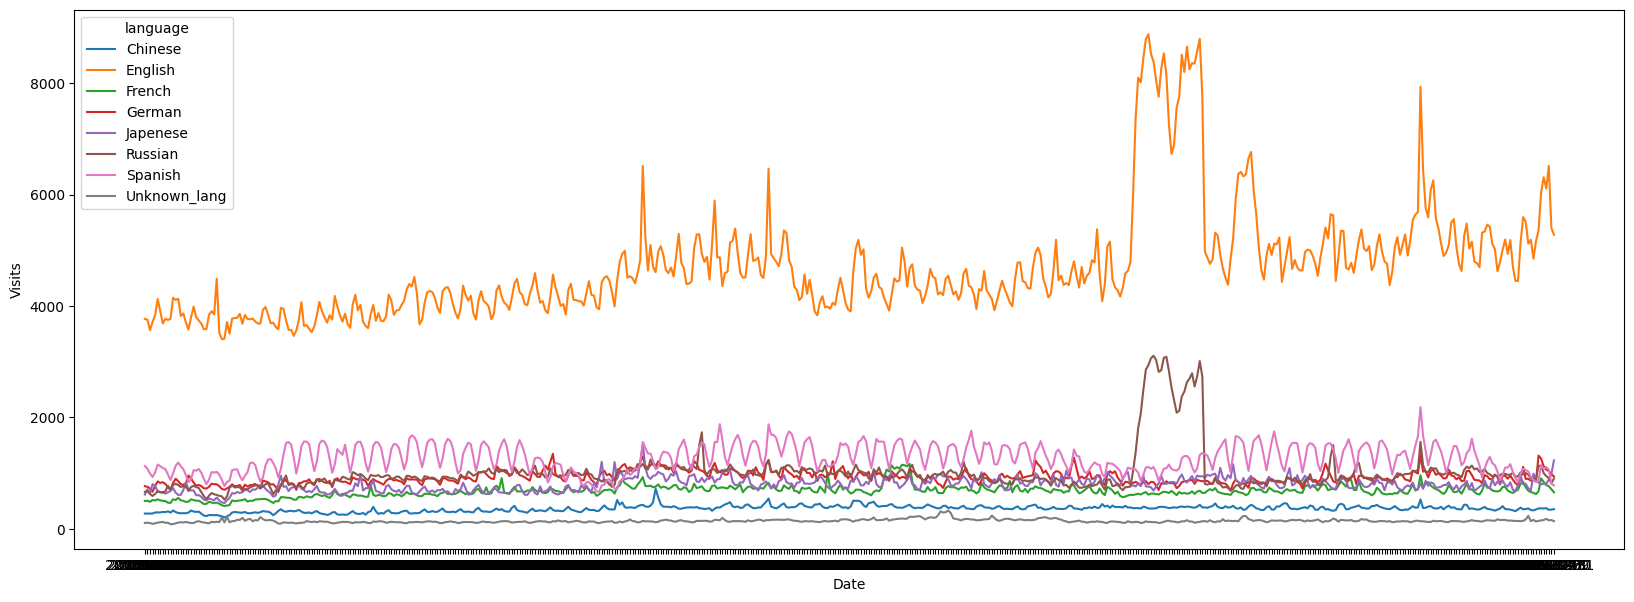

In [24]:
plt.figure(figsize=(20, 7))
sns.lineplot(data=lang_data, y ='Visits',x='Date', hue='language')
plt.show()

- **Above plot shows that articles in english get the most number of views as compared to different languages, there are some spikes at different times in different laguages**

### Checking Stationarity

**Dickey-Fuller test**

- Here the null hypothesis is that the TS is non-stationary.
- The test results comprise of a Test Statistic and some Critical Values for difference confidence levels.

In [25]:
from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    df_output = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key, value in dftest[4].items():
       df_output['Critical Value (%s)' %key] = round(value,2)
    print (df_output)

In [26]:
adf_test(lang_data[lang_data['language'] == 'English']['Visits'])

Results of Dickey-Fuller Test:
Test Statistic                  -2.373563
p-value                          0.149337
#Lags Used                      14.000000
Number of Observations Used    535.000000
Critical Value (1%)             -3.440000
Critical Value (5%)             -2.870000
Critical Value (10%)            -2.570000
dtype: float64


- We see that the p value is not low enough(<0.05). Therefore, we can say our series in not stationary as we fail to reject the null hypothesis

### Making the time series stationary

### 1. Remove trend and seasonality with decomposition

In [27]:
# Naive decomposition of our Time Series
from statsmodels.tsa.seasonal import seasonal_decompose

In [28]:
ts_english = lang_data[lang_data['language'] == 'English']['Visits']

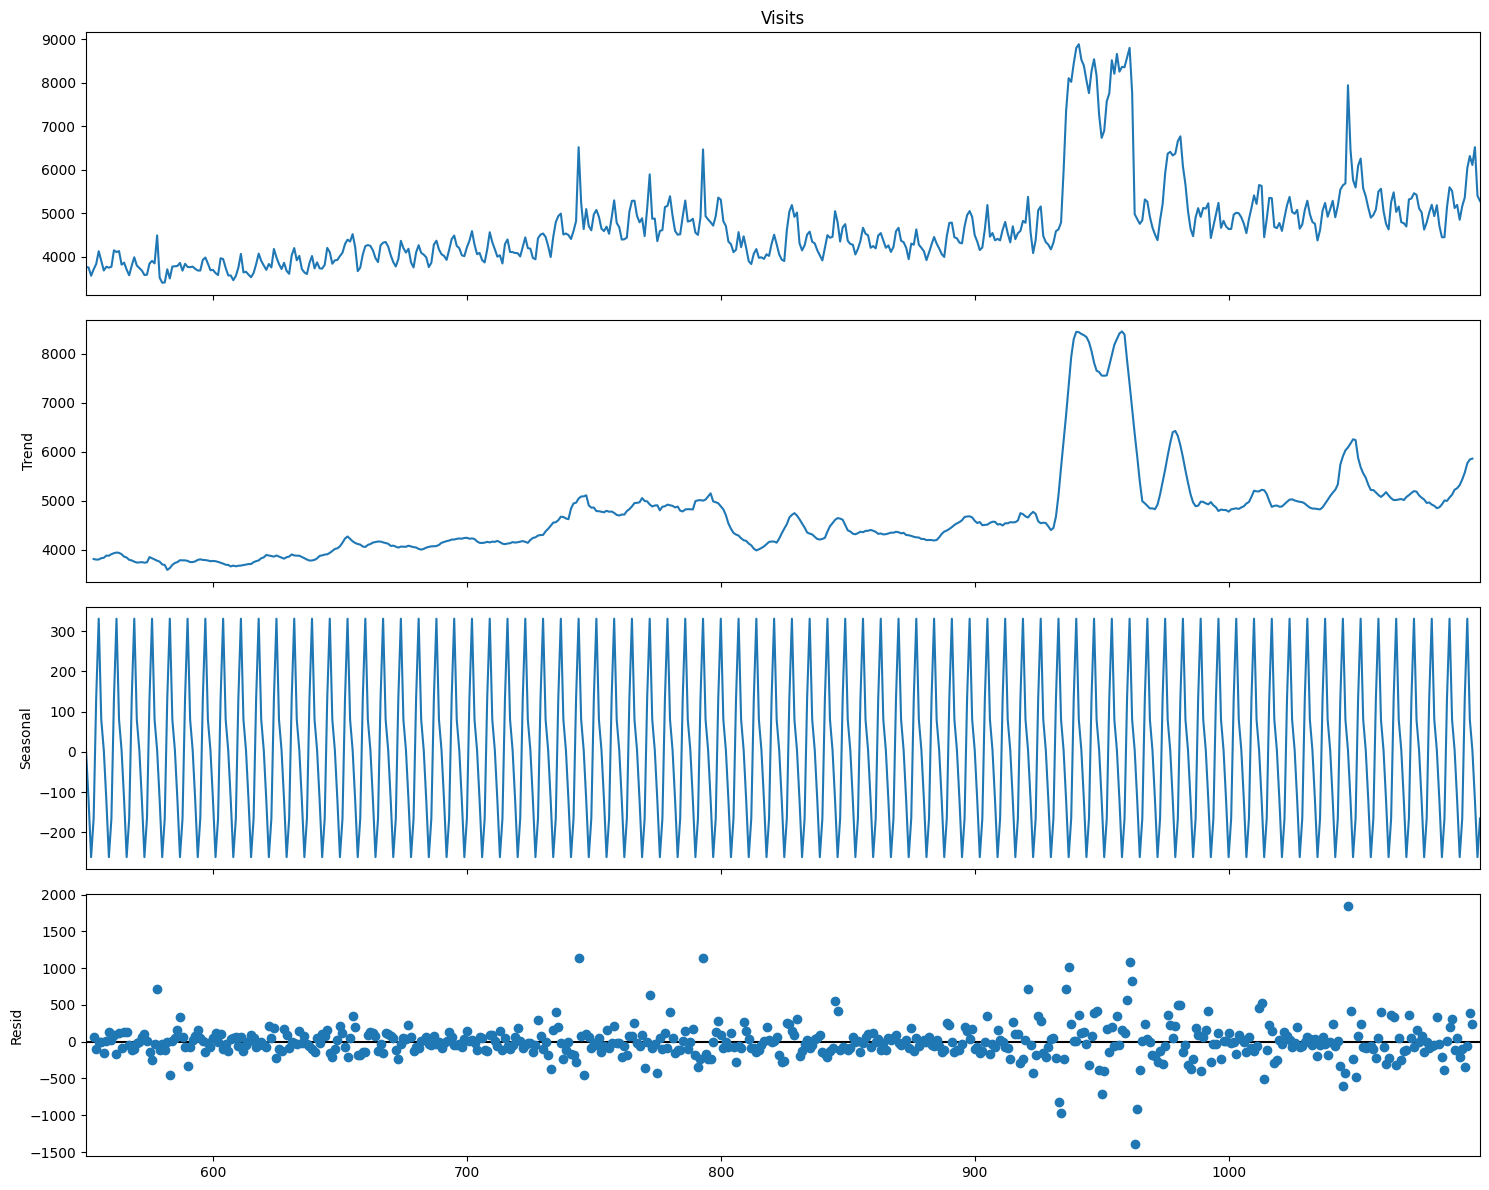

In [29]:

decomposition = seasonal_decompose(ts_english, model='additive', period=7)

fig = decomposition.plot()
fig.set_size_inches((15, 12))
fig.tight_layout()
plt.show()

In [30]:
residual = pd.DataFrame(decomposition.resid.fillna(0).values)
adf_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.152195e+01
p-value                        4.020092e-21
#Lags Used                     1.700000e+01
Number of Observations Used    5.320000e+02
Critical Value (1%)           -3.440000e+00
Critical Value (5%)           -2.870000e+00
Critical Value (10%)          -2.570000e+00
dtype: float64


- We can see that aur series is now stationary, we can also try diffrencing to see what results we can get.

### 2. Remove trend and seasonality with differencing

In [31]:
ts_diff = pd.DataFrame(ts_english).diff(1)
ts_diff.dropna(inplace = True)

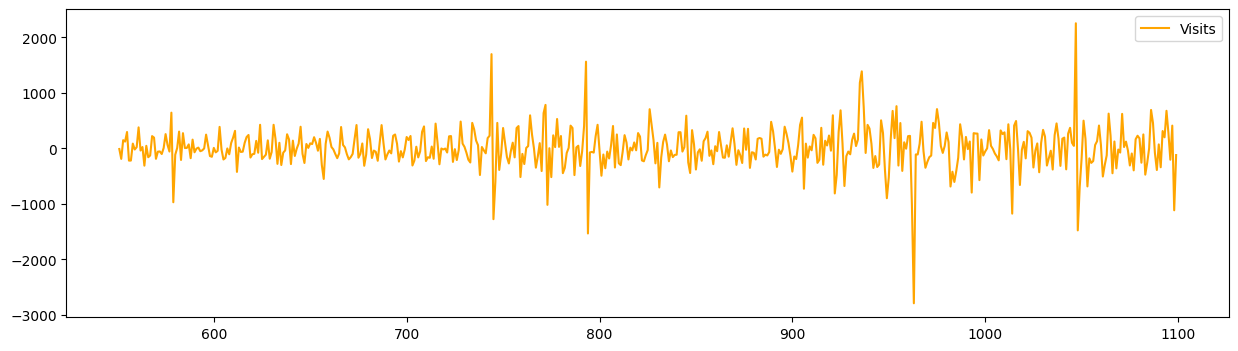

In [32]:
ts_diff.plot(color = 'orange', figsize=(15, 4))
plt.show()

In [33]:
adf_test(ts_diff)

Results of Dickey-Fuller Test:
Test Statistic                -8.273590e+00
p-value                        4.721272e-13
#Lags Used                     1.300000e+01
Number of Observations Used    5.350000e+02
Critical Value (1%)           -3.440000e+00
Critical Value (5%)           -2.870000e+00
Critical Value (10%)          -2.570000e+00
dtype: float64


- Also the p value is 0. So we can say that our graph is now stationery. Now we can apply the ARIMA model

### Plot the autocorreltaion and partial auto correlation functions¶

- Plotting the graphs and getting the p,q,d values for arima

In [34]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

<Figure size 1500x800 with 0 Axes>

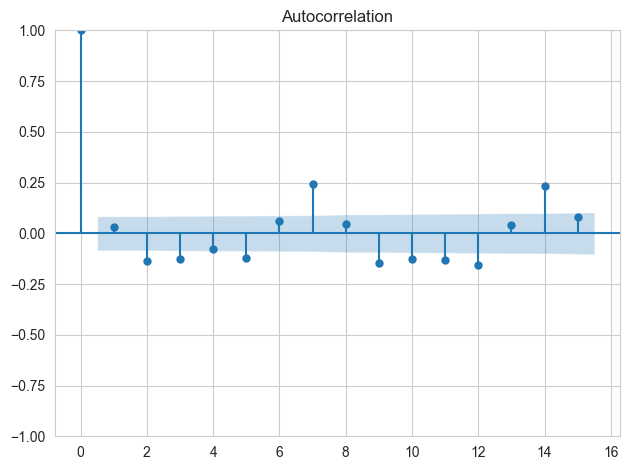

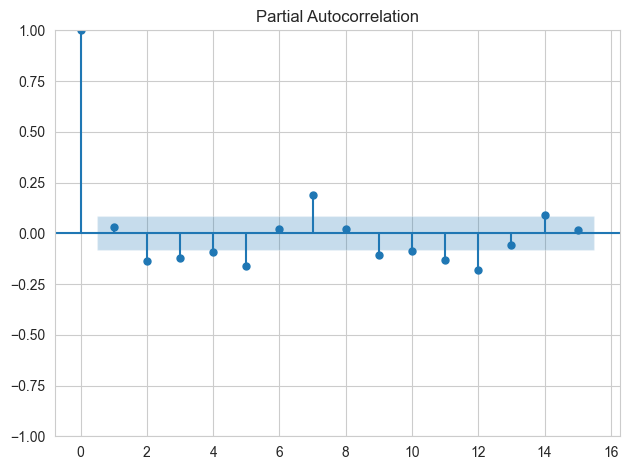

In [35]:
plt.figure(figsize=(15,8))
sns.set_style("whitegrid")
acf = plot_acf(ts_diff, lags= 15)
acf.tight_layout()
pacf = plot_pacf(ts_diff, lags= 15)
pacf.tight_layout()


### ARIMA MODEL

In [36]:
from statsmodels.tsa.arima.model import ARIMA

In [37]:
ts_english = lang_data[lang_data.language == 'English'][['Date', 'Visits']]
ts_english.set_index('Date', drop=True, inplace=True)

In [38]:
def arima_model(n, order, time_series):
    model = ARIMA(time_series[:-n], order=order)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=n, alpha=0.05)
    time_series.index = pd.to_datetime(time_series.index)
    forecast.index = pd.to_datetime(forecast.index)
    
    time_series[-60:].plot(label='Actual')
    forecast.plot(label='Forecast', linestyle='dashed', marker='o', markerfacecolor='green', markersize=2)
    plt.legend(loc="upper right")
    plt.title(f'ARIMA BASE Model {order}: Actual vs Forecasts', fontsize=15, fontweight='bold')
    plt.show()


    actuals = time_series.values[-n:]
    errors = time_series.values[-n:] - forecast.values
    
    mape = np.mean(np.abs(errors) / np.abs(actuals))
    rmse = np.sqrt(np.mean(errors**2))
    
    # Print MAPE & RMSE
    print('-' * 80)
    print(f'MAPE of Model: {np.round(mape, 5)}')
    print('-' * 80)
    print(f'RMSE of Model: {np.round(rmse, 3)}')
    print('-' * 80)

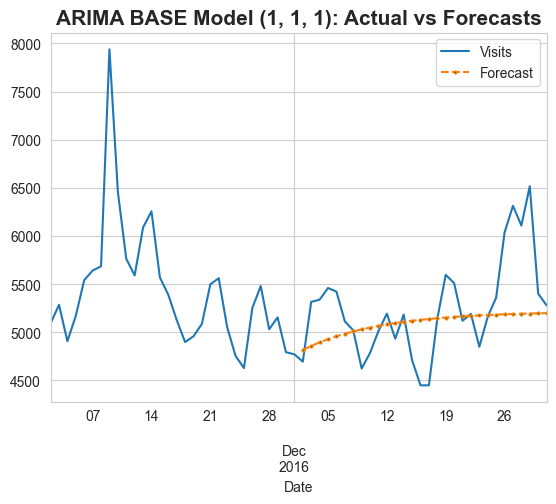

--------------------------------------------------------------------------------
MAPE of Model: 0.07123
--------------------------------------------------------------------------------
RMSE of Model: 527.938
--------------------------------------------------------------------------------


In [39]:
arima_model(30, (1,1,1), ts_english)

- We get the exogenous data from this csv file for english pages 
- we will train a sarimax model for that and see if we get any improvements from using the two information.

- The seasonal order and the values of PDQ are based upon various trials and comparison of the models

- we see a seasonality of 7 from the plots ie: weekly seasonality ( from the plots we can see that afte some insignificant plots we have some significant values repeating at intervals of 7 ie: 7,14 ... )
the non seasonal order we can keep the same

### SARIMAX

In [40]:
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [41]:
def sarimax_model(time_series, n, p=0, d=0, q=0, P=0, D=0, Q=0, s=0, exog = []):
    
    #Creating SARIMAX Model with order(p,d,q) & seasonal_order=(P, D, Q, s) 
    model = SARIMAX(time_series[:-n],
                    order=(p, d, q),
                    seasonal_order=(P, D, Q, s),
                    exog=exog[:-n],
                    initialization='approximate_diffuse')
    model_fit = model.fit()
    
    # Forecasting last n-values
    model_forecast = model_fit.forecast(n, dynamic=True, exog=pd.DataFrame(exog[-n:]))
    
    # Plotting Actual & Forecasted values
    plt.figure(figsize=(20, 8))
    time_series[-60:].plot(label='Actual')
    model_forecast[-60:].plot(label='Forecast', color='red',
                              linestyle='dashed', marker='o', markerfacecolor='green', markersize=5)
    plt.legend(loc="upper right")
    plt.title(f'SARIMAX Model ({p},{d},{q}) ({P},{D},{Q},{s}) : Actual vs Forecasts', fontsize=15, fontweight='bold')
    plt.show()
    
    # Calculating MAPE & RMSE
    actuals = time_series.values[-n:]
    errors = time_series.values[-n:] - model_forecast.values
    
    mape = np.mean(np.abs(errors) / np.abs(actuals))
    rmse = np.sqrt(np.mean(errors ** 2))
    
    # Printing metrics
    print('-' * 80)
    print(f'MAPE of Model : {np.round(mape, 5)}')
    print('-' * 80)
    print(f'RMSE of Model : {np.round(rmse, 3)}')
    print('-' * 80)


<Figure size 2000x800 with 0 Axes>

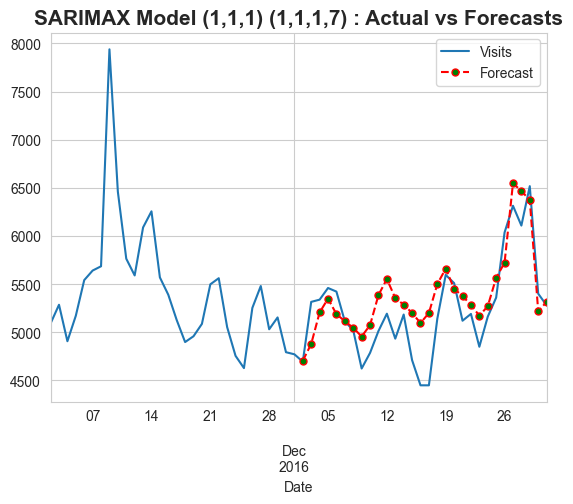

--------------------------------------------------------------------------------
MAPE of Model : 0.09606
--------------------------------------------------------------------------------
RMSE of Model : 663.477
--------------------------------------------------------------------------------


In [42]:
exog = exog['Exog'].to_numpy()
time_series = ts_english
test_size= 0.1
p,d,q, P,D,Q,s = 1,1,1,1,1,1,7
n = 30
sarimax_model(time_series, n, p = p, d=d,q=q,  P=P, D=D, Q=Q, s=s, exog = exog)

- Sarimax algorithm is giving us 9% MAPE value.

### Grid search

In [46]:
def sarimax_grid_search(time_series, n, param, d_param, s_param, exog=[]):
    # Creating df for storing results summary
    param_df = pd.DataFrame(columns=['serial', 'pdq', 'PDQs', 'mape', 'rmse'])
    
    # Generate all parameter combinations
    param_combinations = product(param, d_param, param, param, d_param, param, s_param)
    
    # Counter for keeping track of iterations
    counter = 0
    
    for p, d, q, P, D, Q, s in param_combinations:
        model = SARIMAX(time_series[:-n], 
                        order=(p, d, q), 
                        seasonal_order=(P, D, Q, s), 
                        exog=exog[:-n],
                        initialization='approximate_diffuse')
        model_fit = model.fit()
        
        model_forecast = model_fit.forecast(n, dynamic=True, exog=pd.DataFrame(exog[-n:]))
        
        actuals = time_series.values[-n:]
        errors = time_series.values[-n:] - model_forecast.values
        
        mape = np.mean(np.abs(errors) / np.abs(actuals))
        rmse = np.sqrt(np.mean(errors**2))
        mape = np.round(mape, 5)
        rmse = np.round(rmse, 3)
        
        counter += 1
        list_row = [counter, (p, d, q), (P, D, Q, s), mape, rmse]
        param_df.loc[len(param_df)] = list_row
        
        # Print statement to check progress of Loop                
        print(f'Possible Combination: {counter} out of {len(param)**4 * len(s_param) * len(d_param)**2} calculated')
    
    return param_df

In [47]:
time_series = ts_english
n = 30 
param = [0,1,2]
d_param = [0,1]
s_param = [7]

english_params  = sarimax_grid_search(time_series, n, param, d_param,s_param,exog)

Possible Combination: 1 out of 324 calculated
Possible Combination: 2 out of 324 calculated
Possible Combination: 3 out of 324 calculated
Possible Combination: 4 out of 324 calculated
Possible Combination: 5 out of 324 calculated
Possible Combination: 6 out of 324 calculated
Possible Combination: 7 out of 324 calculated
Possible Combination: 8 out of 324 calculated
Possible Combination: 9 out of 324 calculated
Possible Combination: 10 out of 324 calculated
Possible Combination: 11 out of 324 calculated
Possible Combination: 12 out of 324 calculated
Possible Combination: 13 out of 324 calculated
Possible Combination: 14 out of 324 calculated
Possible Combination: 15 out of 324 calculated
Possible Combination: 16 out of 324 calculated
Possible Combination: 17 out of 324 calculated
Possible Combination: 18 out of 324 calculated
Possible Combination: 19 out of 324 calculated
Possible Combination: 20 out of 324 calculated
Possible Combination: 21 out of 324 calculated
Possible Combination: 

Possible Combination: 174 out of 324 calculated
Possible Combination: 175 out of 324 calculated
Possible Combination: 176 out of 324 calculated
Possible Combination: 177 out of 324 calculated
Possible Combination: 178 out of 324 calculated
Possible Combination: 179 out of 324 calculated
Possible Combination: 180 out of 324 calculated
Possible Combination: 181 out of 324 calculated
Possible Combination: 182 out of 324 calculated
Possible Combination: 183 out of 324 calculated
Possible Combination: 184 out of 324 calculated
Possible Combination: 185 out of 324 calculated
Possible Combination: 186 out of 324 calculated
Possible Combination: 187 out of 324 calculated
Possible Combination: 188 out of 324 calculated
Possible Combination: 189 out of 324 calculated
Possible Combination: 190 out of 324 calculated
Possible Combination: 191 out of 324 calculated
Possible Combination: 192 out of 324 calculated
Possible Combination: 193 out of 324 calculated
Possible Combination: 194 out of 324 cal

In [48]:
english_params.sort_values(['mape', 'rmse']).head()

,serial,pdq,PDQs,mape,rmse
199,200,"(1, 1, 2)","(0, 0, 1, 7)",0.08417,607.501
289,290,"(2, 1, 1)","(0, 0, 1, 7)",0.08420,607.705
290,291,"(2, 1, 1)","(0, 0, 2, 7)",0.08462,610.001
308,309,"(2, 1, 2)","(0, 0, 2, 7)",0.08471,610.459
48,49,"(0, 0, 2)","(2, 0, 0, 7)",0.08474,594.641


<Figure size 2000x800 with 0 Axes>

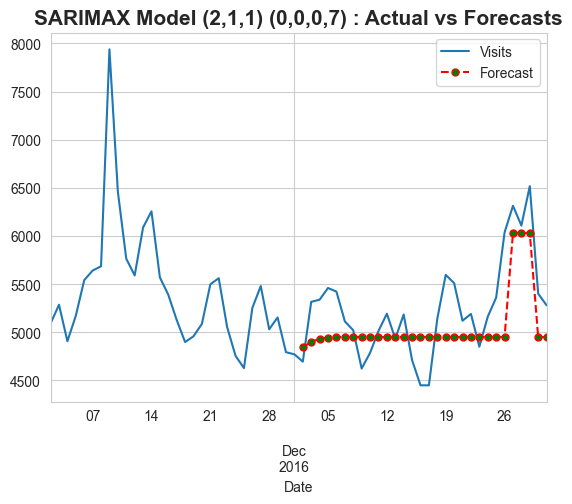

--------------------------------------------------------------------------------
MAPE of Model : 0.08806
--------------------------------------------------------------------------------
RMSE of Model : 622.486
--------------------------------------------------------------------------------


In [49]:
time_series = ts_english

p,d,q, P,D,Q,s = 2,1,1, 0,0,0,7
n = 30
sarimax_model(time_series, n, p=p, d=d, q=q, P=P, D=D, Q=Q, s=s, exog = exog)

<Figure size 2000x800 with 0 Axes>

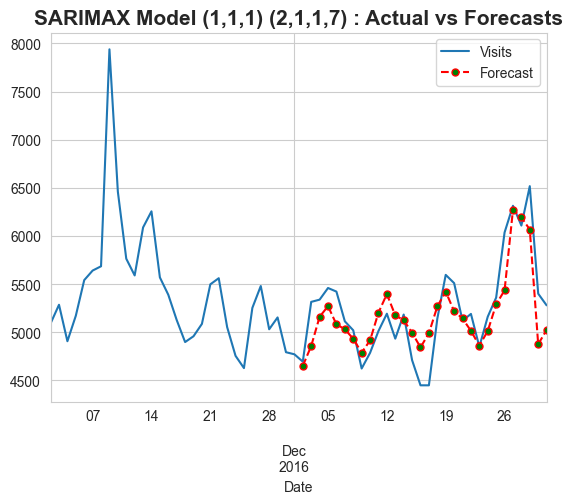

--------------------------------------------------------------------------------
MAPE of Model : 0.08888
--------------------------------------------------------------------------------
RMSE of Model : 627.098
--------------------------------------------------------------------------------


In [50]:
time_series = ts_english
p,d,q, P,D,Q,s = 1,1,1, 2,1,1,7
n = 30
sarimax_model(time_series, n, p=p, d=d, q=q, P=P, D=D, Q=Q, s=s, exog = exog)

### Comparing the predicted views for different languages

In [51]:
def pipeline_sarimax_grid_search_without_exog(languages, data_language, n, param, d_param, s_param):
    
    best_param_df = pd.DataFrame(columns=['language', 'p', 'd', 'q', 'P', 'D', 'Q', 's', 'mape'])
    
    for lang in languages:
        print(f'--------------------------------------------------------------')
        print(f'          Finding best parameters for {lang}                  ')
        print(f'--------------------------------------------------------------')
        
        time_series = data_language[data_language['language'] == lang][['Date', 'Visits']]
        time_series.set_index('Date', drop=True, inplace=True)
        best_mape = 100
        
        counter = 0
        param_combinations = product(param, d_param, param, param, d_param, param, s_param)
        
        for p, d, q, P, D, Q, s in param_combinations:
            model = SARIMAX(time_series[:-n], 
                            order=(p, d, q), 
                            seasonal_order=(P, D, Q, s), 
                            initialization='approximate_diffuse')
            model_fit = model.fit()
            model_forecast = model_fit.forecast(n, dynamic=True)
            
            actuals = time_series.values[-n:]
            errors = time_series.values[-n:] - model_forecast.values
            mape = np.mean(np.abs(errors) / np.abs(actuals))
            
            counter += 1
            if mape < best_mape:
                best_mape = mape
                best_p, best_d, best_q = p, d, q
                best_P, best_D, best_Q = P, D, Q
                best_s = s
            
            print(f'Possible Combination: {counter} out of {(len(param)**4)*len(s_param)*(len(d_param)**2)} calculated')

        best_mape = np.round(best_mape, 5)
        print(f'--------------------------------------------------------------')
        print(f'Minimum MAPE for {lang} = {best_mape}')
        print(f'Corresponding Best Parameters are {best_p, best_d, best_q, best_P, best_D, best_Q, best_s}')
        print(f'--------------------------------------------------------------')
        
        best_param_row = [lang, best_p, best_d, best_q, best_P, best_D, best_Q, best_s, best_mape]
        best_param_df.loc[len(best_param_df)] = best_param_row                
                           
    return best_param_df

In [52]:
languages = ['Chinese', 'French', 'German', 'Japenese', 'Russian', 'Spanish']
n = 30 
param = [0,1,2]
d_param = [0,1]
s_param = [7]


best_param_df = pipeline_sarimax_grid_search_without_exog(languages, lang_data, n, param, d_param, s_param)

--------------------------------------------------------------
          Finding best parameters for Chinese                  
--------------------------------------------------------------
Possible Combination: 1 out of 324 calculated
Possible Combination: 2 out of 324 calculated
Possible Combination: 3 out of 324 calculated
Possible Combination: 4 out of 324 calculated
Possible Combination: 5 out of 324 calculated
Possible Combination: 6 out of 324 calculated
Possible Combination: 7 out of 324 calculated
Possible Combination: 8 out of 324 calculated
Possible Combination: 9 out of 324 calculated
Possible Combination: 10 out of 324 calculated
Possible Combination: 11 out of 324 calculated
Possible Combination: 12 out of 324 calculated
Possible Combination: 13 out of 324 calculated
Possible Combination: 14 out of 324 calculated
Possible Combination: 15 out of 324 calculated
Possible Combination: 16 out of 324 calculated
Possible Combination: 17 out of 324 calculated
Possible Combination

Possible Combination: 170 out of 324 calculated
Possible Combination: 171 out of 324 calculated
Possible Combination: 172 out of 324 calculated
Possible Combination: 173 out of 324 calculated
Possible Combination: 174 out of 324 calculated
Possible Combination: 175 out of 324 calculated
Possible Combination: 176 out of 324 calculated
Possible Combination: 177 out of 324 calculated
Possible Combination: 178 out of 324 calculated
Possible Combination: 179 out of 324 calculated
Possible Combination: 180 out of 324 calculated
Possible Combination: 181 out of 324 calculated
Possible Combination: 182 out of 324 calculated
Possible Combination: 183 out of 324 calculated
Possible Combination: 184 out of 324 calculated
Possible Combination: 185 out of 324 calculated
Possible Combination: 186 out of 324 calculated
Possible Combination: 187 out of 324 calculated
Possible Combination: 188 out of 324 calculated
Possible Combination: 189 out of 324 calculated
Possible Combination: 190 out of 324 cal

Possible Combination: 9 out of 324 calculated
Possible Combination: 10 out of 324 calculated
Possible Combination: 11 out of 324 calculated
Possible Combination: 12 out of 324 calculated
Possible Combination: 13 out of 324 calculated
Possible Combination: 14 out of 324 calculated
Possible Combination: 15 out of 324 calculated
Possible Combination: 16 out of 324 calculated
Possible Combination: 17 out of 324 calculated
Possible Combination: 18 out of 324 calculated
Possible Combination: 19 out of 324 calculated
Possible Combination: 20 out of 324 calculated
Possible Combination: 21 out of 324 calculated
Possible Combination: 22 out of 324 calculated
Possible Combination: 23 out of 324 calculated
Possible Combination: 24 out of 324 calculated
Possible Combination: 25 out of 324 calculated
Possible Combination: 26 out of 324 calculated
Possible Combination: 27 out of 324 calculated
Possible Combination: 28 out of 324 calculated
Possible Combination: 29 out of 324 calculated
Possible Combi

Possible Combination: 182 out of 324 calculated
Possible Combination: 183 out of 324 calculated
Possible Combination: 184 out of 324 calculated
Possible Combination: 185 out of 324 calculated
Possible Combination: 186 out of 324 calculated
Possible Combination: 187 out of 324 calculated
Possible Combination: 188 out of 324 calculated
Possible Combination: 189 out of 324 calculated
Possible Combination: 190 out of 324 calculated
Possible Combination: 191 out of 324 calculated
Possible Combination: 192 out of 324 calculated
Possible Combination: 193 out of 324 calculated
Possible Combination: 194 out of 324 calculated
Possible Combination: 195 out of 324 calculated
Possible Combination: 196 out of 324 calculated
Possible Combination: 197 out of 324 calculated
Possible Combination: 198 out of 324 calculated
Possible Combination: 199 out of 324 calculated
Possible Combination: 200 out of 324 calculated
Possible Combination: 201 out of 324 calculated
Possible Combination: 202 out of 324 cal

Possible Combination: 21 out of 324 calculated
Possible Combination: 22 out of 324 calculated
Possible Combination: 23 out of 324 calculated
Possible Combination: 24 out of 324 calculated
Possible Combination: 25 out of 324 calculated
Possible Combination: 26 out of 324 calculated
Possible Combination: 27 out of 324 calculated
Possible Combination: 28 out of 324 calculated
Possible Combination: 29 out of 324 calculated
Possible Combination: 30 out of 324 calculated
Possible Combination: 31 out of 324 calculated
Possible Combination: 32 out of 324 calculated
Possible Combination: 33 out of 324 calculated
Possible Combination: 34 out of 324 calculated
Possible Combination: 35 out of 324 calculated
Possible Combination: 36 out of 324 calculated
Possible Combination: 37 out of 324 calculated
Possible Combination: 38 out of 324 calculated
Possible Combination: 39 out of 324 calculated
Possible Combination: 40 out of 324 calculated
Possible Combination: 41 out of 324 calculated
Possible Comb

Possible Combination: 194 out of 324 calculated
Possible Combination: 195 out of 324 calculated
Possible Combination: 196 out of 324 calculated
Possible Combination: 197 out of 324 calculated
Possible Combination: 198 out of 324 calculated
Possible Combination: 199 out of 324 calculated
Possible Combination: 200 out of 324 calculated
Possible Combination: 201 out of 324 calculated
Possible Combination: 202 out of 324 calculated
Possible Combination: 203 out of 324 calculated
Possible Combination: 204 out of 324 calculated
Possible Combination: 205 out of 324 calculated
Possible Combination: 206 out of 324 calculated
Possible Combination: 207 out of 324 calculated
Possible Combination: 208 out of 324 calculated
Possible Combination: 209 out of 324 calculated
Possible Combination: 210 out of 324 calculated
Possible Combination: 211 out of 324 calculated
Possible Combination: 212 out of 324 calculated
Possible Combination: 213 out of 324 calculated
Possible Combination: 214 out of 324 cal

Possible Combination: 34 out of 324 calculated
Possible Combination: 35 out of 324 calculated
Possible Combination: 36 out of 324 calculated
Possible Combination: 37 out of 324 calculated
Possible Combination: 38 out of 324 calculated
Possible Combination: 39 out of 324 calculated
Possible Combination: 40 out of 324 calculated
Possible Combination: 41 out of 324 calculated
Possible Combination: 42 out of 324 calculated
Possible Combination: 43 out of 324 calculated
Possible Combination: 44 out of 324 calculated
Possible Combination: 45 out of 324 calculated
Possible Combination: 46 out of 324 calculated
Possible Combination: 47 out of 324 calculated
Possible Combination: 48 out of 324 calculated
Possible Combination: 49 out of 324 calculated
Possible Combination: 50 out of 324 calculated
Possible Combination: 51 out of 324 calculated
Possible Combination: 52 out of 324 calculated
Possible Combination: 53 out of 324 calculated
Possible Combination: 54 out of 324 calculated
Possible Comb

Possible Combination: 207 out of 324 calculated
Possible Combination: 208 out of 324 calculated
Possible Combination: 209 out of 324 calculated
Possible Combination: 210 out of 324 calculated
Possible Combination: 211 out of 324 calculated
Possible Combination: 212 out of 324 calculated
Possible Combination: 213 out of 324 calculated
Possible Combination: 214 out of 324 calculated
Possible Combination: 215 out of 324 calculated
Possible Combination: 216 out of 324 calculated
Possible Combination: 217 out of 324 calculated
Possible Combination: 218 out of 324 calculated
Possible Combination: 219 out of 324 calculated
Possible Combination: 220 out of 324 calculated
Possible Combination: 221 out of 324 calculated
Possible Combination: 222 out of 324 calculated
Possible Combination: 223 out of 324 calculated
Possible Combination: 224 out of 324 calculated
Possible Combination: 225 out of 324 calculated
Possible Combination: 226 out of 324 calculated
Possible Combination: 227 out of 324 cal

Possible Combination: 47 out of 324 calculated
Possible Combination: 48 out of 324 calculated
Possible Combination: 49 out of 324 calculated
Possible Combination: 50 out of 324 calculated
Possible Combination: 51 out of 324 calculated
Possible Combination: 52 out of 324 calculated
Possible Combination: 53 out of 324 calculated
Possible Combination: 54 out of 324 calculated
Possible Combination: 55 out of 324 calculated
Possible Combination: 56 out of 324 calculated
Possible Combination: 57 out of 324 calculated
Possible Combination: 58 out of 324 calculated
Possible Combination: 59 out of 324 calculated
Possible Combination: 60 out of 324 calculated
Possible Combination: 61 out of 324 calculated
Possible Combination: 62 out of 324 calculated
Possible Combination: 63 out of 324 calculated
Possible Combination: 64 out of 324 calculated
Possible Combination: 65 out of 324 calculated
Possible Combination: 66 out of 324 calculated
Possible Combination: 67 out of 324 calculated
Possible Comb

Possible Combination: 219 out of 324 calculated
Possible Combination: 220 out of 324 calculated
Possible Combination: 221 out of 324 calculated
Possible Combination: 222 out of 324 calculated
Possible Combination: 223 out of 324 calculated
Possible Combination: 224 out of 324 calculated
Possible Combination: 225 out of 324 calculated
Possible Combination: 226 out of 324 calculated
Possible Combination: 227 out of 324 calculated
Possible Combination: 228 out of 324 calculated
Possible Combination: 229 out of 324 calculated
Possible Combination: 230 out of 324 calculated
Possible Combination: 231 out of 324 calculated
Possible Combination: 232 out of 324 calculated
Possible Combination: 233 out of 324 calculated
Possible Combination: 234 out of 324 calculated
Possible Combination: 235 out of 324 calculated
Possible Combination: 236 out of 324 calculated
Possible Combination: 237 out of 324 calculated
Possible Combination: 238 out of 324 calculated
Possible Combination: 239 out of 324 cal

Possible Combination: 60 out of 324 calculated
Possible Combination: 61 out of 324 calculated
Possible Combination: 62 out of 324 calculated
Possible Combination: 63 out of 324 calculated
Possible Combination: 64 out of 324 calculated
Possible Combination: 65 out of 324 calculated
Possible Combination: 66 out of 324 calculated
Possible Combination: 67 out of 324 calculated
Possible Combination: 68 out of 324 calculated
Possible Combination: 69 out of 324 calculated
Possible Combination: 70 out of 324 calculated
Possible Combination: 71 out of 324 calculated
Possible Combination: 72 out of 324 calculated
Possible Combination: 73 out of 324 calculated
Possible Combination: 74 out of 324 calculated
Possible Combination: 75 out of 324 calculated
Possible Combination: 76 out of 324 calculated
Possible Combination: 77 out of 324 calculated
Possible Combination: 78 out of 324 calculated
Possible Combination: 79 out of 324 calculated
Possible Combination: 80 out of 324 calculated
Possible Comb

Possible Combination: 232 out of 324 calculated
Possible Combination: 233 out of 324 calculated
Possible Combination: 234 out of 324 calculated
Possible Combination: 235 out of 324 calculated
Possible Combination: 236 out of 324 calculated
Possible Combination: 237 out of 324 calculated
Possible Combination: 238 out of 324 calculated
Possible Combination: 239 out of 324 calculated
Possible Combination: 240 out of 324 calculated
Possible Combination: 241 out of 324 calculated
Possible Combination: 242 out of 324 calculated
Possible Combination: 243 out of 324 calculated
Possible Combination: 244 out of 324 calculated
Possible Combination: 245 out of 324 calculated
Possible Combination: 246 out of 324 calculated
Possible Combination: 247 out of 324 calculated
Possible Combination: 248 out of 324 calculated
Possible Combination: 249 out of 324 calculated
Possible Combination: 250 out of 324 calculated
Possible Combination: 251 out of 324 calculated
Possible Combination: 252 out of 324 cal

In [53]:
best_param_df.sort_values(['mape'], inplace = True)
best_param_df

,language,p,d,q,P,D,Q,s,mape
0,Chinese,2,1,0,0,0,0,7,0.03932
4,Russian,0,0,2,2,0,2,7,0.05953
1,French,2,0,1,0,0,0,7,0.07404
2,German,1,0,1,0,0,0,7,0.08424
3,Japenese,1,0,0,0,1,1,7,0.09069
5,Spanish,1,0,0,0,0,1,7,0.14471


In [55]:
def plot_best_SARIMAX_model(languages, data_language, n, best_param_df):
    for lang in languages:
        # Fetching respective best parameters for that language
        params_lang = best_param_df[best_param_df['language'] == lang].iloc[0]
        p, d, q, P, D, Q, s = params_lang[['p', 'd', 'q', 'P', 'D', 'Q', 's']]

        # Creating language time-series
        time_series = data_language[data_language['language'] == lang][['Date', 'Visits']]
        time_series.set_index('Date', drop=True, inplace=True)
        
        # Creating SARIMAX Model
        model = SARIMAX(time_series[:-n], order=(p, d, q),
                        seasonal_order=(P, D, Q, s), initialization='approximate_diffuse')
        model_fit = model.fit()

        # Creating forecast for last n-values
        model_forecast = model_fit.forecast(n, dynamic=True)

        # Calculating MAPE & RMSE
        actuals = time_series.values[-n:]
        errors = time_series.values[-n:] - model_forecast.values
        mape = np.mean(np.abs(errors) / np.abs(actuals))
        rmse = np.sqrt(np.mean(errors**2))

        # Printing model statistics
        print(f'\n{"-" * 90}')
        print(f'SARIMAX model for {lang} Time Series')
        print(f'Parameters of Model: ({p}, {d}, {q}) ({P}, {D}, {Q}, {s})')
        print(f'MAPE of Model: {np.round(mape, 5)}')
        print(f'RMSE of Model: {np.round(rmse, 3)}')
        print(f'{"-" * 90}')

        # Plotting Actual & Forecasted values
        time_series.index = time_series.index.astype('datetime64[ns]')
        model_forecast.index = model_forecast.index.astype('datetime64[ns]')
        plt.figure(figsize=(20, 8))
        time_series[-60:].plot(label='Actual')
        model_forecast[-60:].plot(label='Forecast', color='red',
                                  linestyle='dashed', marker='o', markerfacecolor='green', markersize=5)
        plt.legend(loc="upper right")
        plt.title(f'SARIMAX Model ({p}, {d}, {q}) ({P}, {D}, {Q}, {s}): Actual vs Forecasts',
                  fontsize=15, fontweight='bold')
        plt.show()

    return 0


------------------------------------------------------------------------------------------
SARIMAX model for Chinese Time Series
Parameters of Model: (2, 1, 0) (0, 0, 0, 7)
MAPE of Model: 0.03932
RMSE of Model: 19.06
------------------------------------------------------------------------------------------


<Figure size 2000x800 with 0 Axes>

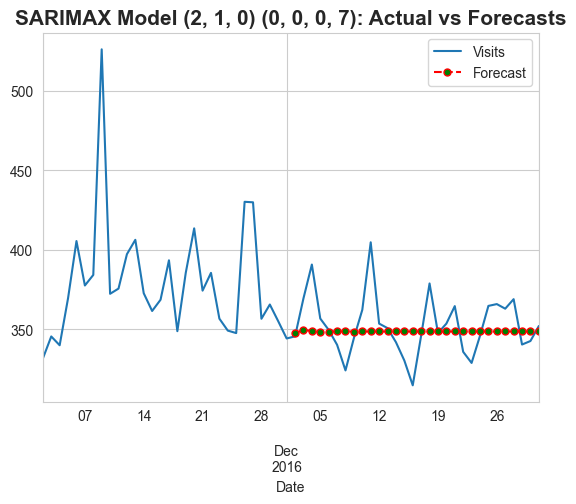


------------------------------------------------------------------------------------------
SARIMAX model for French Time Series
Parameters of Model: (2, 0, 1) (0, 0, 0, 7)
MAPE of Model: 0.07404
RMSE of Model: 77.314
------------------------------------------------------------------------------------------


<Figure size 2000x800 with 0 Axes>

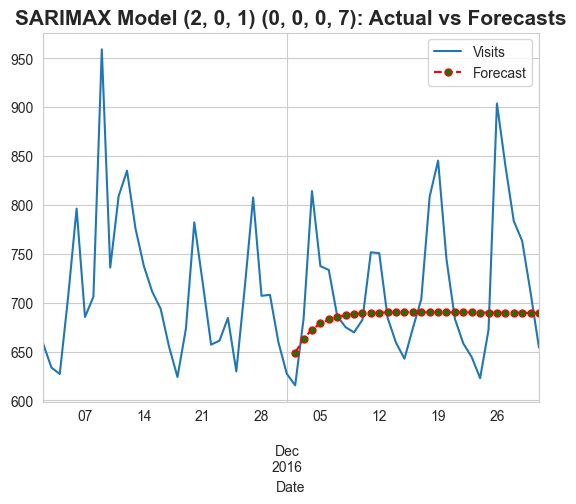


------------------------------------------------------------------------------------------
SARIMAX model for German Time Series
Parameters of Model: (1, 0, 1) (0, 0, 0, 7)
MAPE of Model: 0.08424
RMSE of Model: 125.263
------------------------------------------------------------------------------------------


<Figure size 2000x800 with 0 Axes>

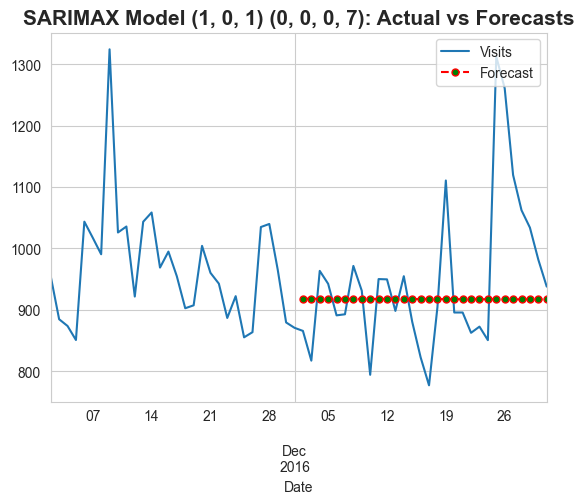


------------------------------------------------------------------------------------------
SARIMAX model for Japenese Time Series
Parameters of Model: (1, 0, 0) (0, 1, 1, 7)
MAPE of Model: 0.09069
RMSE of Model: 116.392
------------------------------------------------------------------------------------------


<Figure size 2000x800 with 0 Axes>

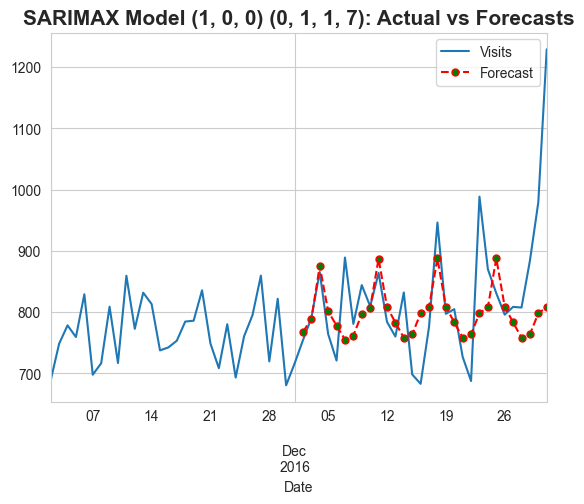


------------------------------------------------------------------------------------------
SARIMAX model for Russian Time Series
Parameters of Model: (0, 0, 2) (2, 0, 2, 7)
MAPE of Model: 0.05953
RMSE of Model: 78.001
------------------------------------------------------------------------------------------


<Figure size 2000x800 with 0 Axes>

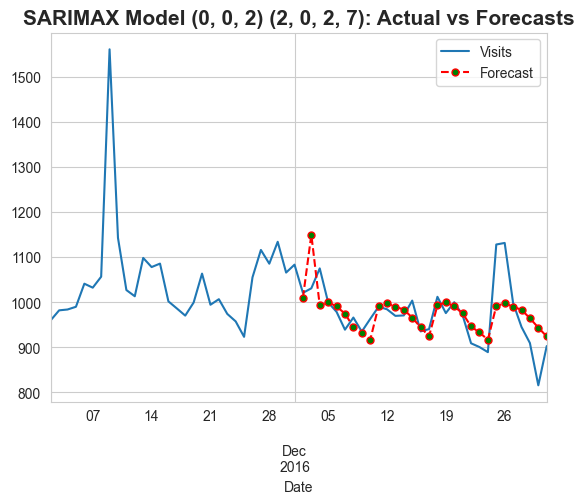


------------------------------------------------------------------------------------------
SARIMAX model for Spanish Time Series
Parameters of Model: (1, 0, 0) (0, 0, 1, 7)
MAPE of Model: 0.14471
RMSE of Model: 175.659
------------------------------------------------------------------------------------------


<Figure size 2000x800 with 0 Axes>

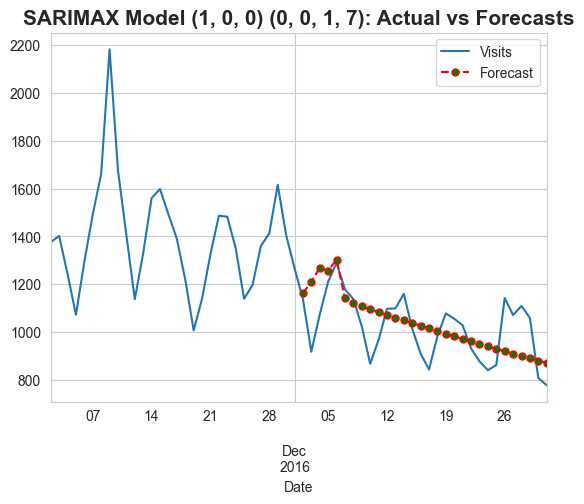

0

In [56]:
languages = ['Chinese', 'French', 'German', 'Japenese', 'Russian', 'Spanish']
n = 30 
plot_best_SARIMAX_model(languages, lang_data, n, best_param_df)

## Using FB Prophet

In [57]:

time_series = lang_data[lang_data['language'] == 'English'][['Date', 'Visits']]
# time_series.set_index('Date', drop=True, inplace=True)
time_series.columns = ['ds', 'y']
time_series['exog'] = exog

13:48:50 - cmdstanpy - INFO - Chain [1] start processing
13:48:50 - cmdstanpy - INFO - Chain [1] done processing


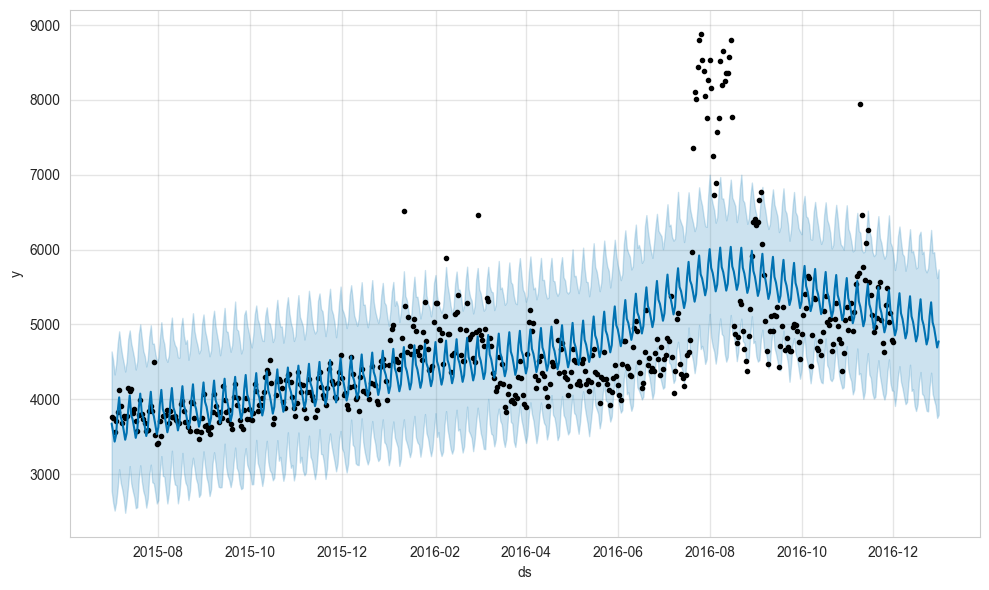

In [62]:
prophet1 = Prophet(weekly_seasonality=True)
prophet1.fit(time_series[['ds', 'y']][:-30])
future = prophet1.make_future_dataframe(periods=30, freq= 'D')
forecast = prophet1.predict(future)
fig1 = prophet1.plot(forecast)

13:49:28 - cmdstanpy - INFO - Chain [1] start processing
13:49:28 - cmdstanpy - INFO - Chain [1] done processing


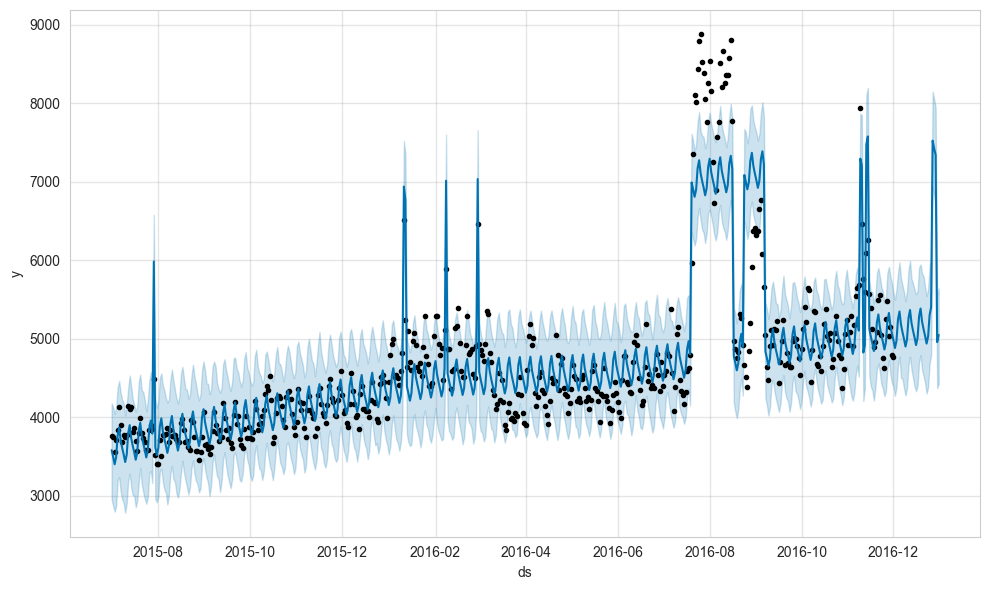

In [63]:
prophet2 = Prophet(weekly_seasonality=True)
prophet2.add_regressor('exog')
prophet2.fit(time_series[:-30])
#future2 = prophet2.make_future_dataframe(periods=30, freq= 'D')
forecast2 = prophet2.predict(time_series)
fig2 = prophet2.plot(forecast2)

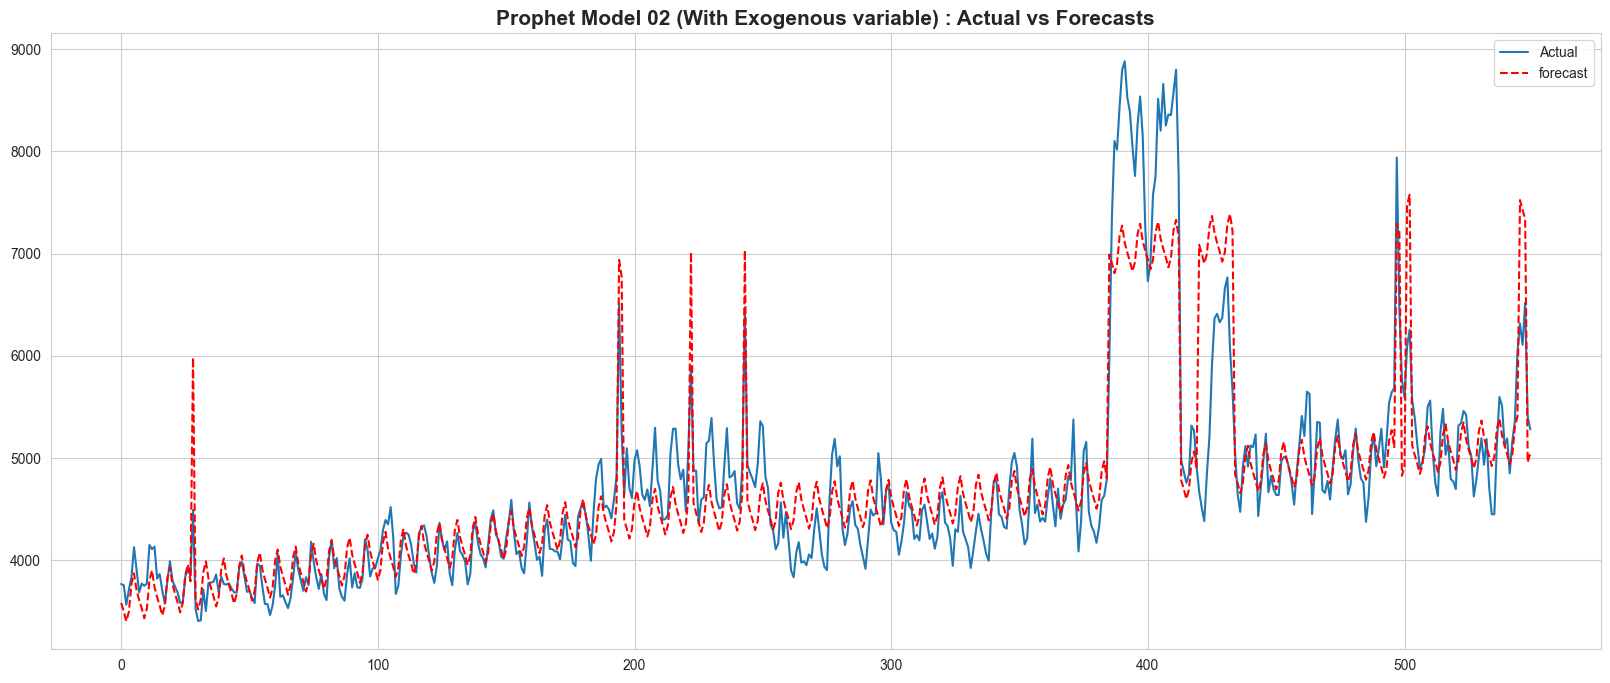

In [64]:
actual = time_series['y'].values
forecast = forecast2['yhat'].values

plt.figure(figsize = (20,8))
plt.plot(actual, label = 'Actual')
plt.plot(forecast, label = 'forecast', color = 'red', linestyle='dashed')
plt.legend(loc="upper right")
plt.title(f'Prophet Model 02 (With Exogenous variable) : Actual vs Forecasts', fontsize = 15, fontweight = 'bold')
plt.show()

In [65]:
errors = abs(actual - forecast)
mape = np.mean(errors/abs(actual))
mape

0.059846174776769345

- **FB Prophet Model is able to capture peaks because of exogenous variable and is giving a MAPE of 6%**

## Insight

**Data Preprocessing:**

   - Over time, there has been a decrease in the number of missing values, indicating improved data collection or website creation.
   - Some websites initially have all missing values, possibly due to being created after the data collection period.
   - Null values spanning over 300 days were removed, ensuring meaningful context in the time series.
Remaining missing values were imputed with zeros under the assumption of no traffic recorded on those dates.


**Exploratory Data Analysis (EDA):**

   - English language articles receive the highest number of visits compared to other languages.
   - Both desktop and mobile access have similar usage patterns.
Organic views significantly surpass spider views.


**Modeling:**

   - Stationarity was achieved through decomposition and differencing.
ARIMA models were utilized initially, achieving a Mean Absolute Percentage Error (MAPE) of 0.07123 and Root Mean Square Error (RMSE) of 527 for English language data.
   - Incorporating exogenous variables from the provided CSV file, SARIMAX models were trained, resulting in improved performance with a MAPE of 0.08 and RMSE of 622 for English language data.


**Model Comparison:**

   -  SARIMAX models with exogenous variables outperformed traditional ARIMA models, indicating the importance of incorporating external factors.
Grid search was employed to optimize model parameters, further enhancing performance.
   - Models were built for each language, with Chinese achieving the lowest MAPE of 0.039, followed by Russian (MAPE: 0.05) and French (MAPE: 0.07).


**Alternative Modeling Approach:**

   - FB Prophet models were employed, leveraging exogenous variables to capture peaks effectively and yielding a MAPE of 6%.

## Recommendations:

**Prioritize English Language Pages:**
- Focus advertising efforts on English language pages due to their low MAPE and high mean visits, maximizing reach and effectiveness.


**Chinese Language Pages:**

Avoid advertising on Chinese language pages unless there's a specific marketing strategy tailored for Chinese populations, as they have the lowest number of visits.

**Russian Language Pages:**
 - Explore advertising opportunities on Russian language pages, as they present a promising opportunity for high conversion rates with their decent number of visits and low MAPE if utilized effectively.
 
 
**Spanish Language Pages:**
   - Exercise caution when advertising on Spanish language pages despite their second-highest number of visits, as they exhibit the highest MAPE. Advertisements on these pages may not effectively reach the intended audience.
   
   
**French, German, and Japanese Language Pages:**

  - Consider advertising campaigns on French, German, and Japanese language pages, as they show moderate levels of visits and MAPE. Depending on the target customers, these pages offer potential reach and conversion rates worth capitalizing on.

## Questionnaire:

1. Defining the problem statements and where can this and modifications of this be used?

   Answer:  At AdEase, the Data Science team is tasked with analyzing per-page view reports for Wikipedia pages over a 550-day period. The primary goal is to forecast page views to optimize ad placement for clients. With a dataset covering 145,000 Wikipedia pages and daily view counts, the project aims to provide insights into ad performance across various languages and regions.


2. Write 3 inferences you made from the data visualizations.
- Answer: 

   Linguistic Diversity: The analysis indicates the presence of seven languages, with English being the most prevalent, followed by Japanese, German, and French.

   Access Type Distribution: Access types are segmented into All-access, mobile-web, and desktop, with proportions of 51.4%, 24.9%, and 23.6% respectively.
   
    Access-Origin Insights: The data highlights two access origins—'all-agents' and 'spider'—with the majority of access coming from 'all-agents' (75.8%) compared to 'spider' (24.2%).


3. What does the decomposition of series do?

Answer: Time series decomposition is a statistical approach employed to dissect a time series into its fundamental components, allowing for a better grasp of its underlying structure, including trends, seasonality, and irregular fluctuations.

4. What level of differencing gave you a stationary series?

Answer:  First-order differencing was applied to achieve stationarity in the series.


5. Difference between arima, sarima & sarimax.

Answer: 

ARIMA: A comprehensive time series forecasting model incorporating autoregression (AR), differencing (I), and moving average (MA) 
components, suitable for univariate time series data without exogenous variables.


SARIMA: An advanced version of ARIMA that includes seasonal components, ideal for time series data with seasonal patterns.


SARIMAX: An extension of SARIMA allowing for the inclusion of exogenous variables, making it suitable for time series data with both seasonal patterns and external factors.


In [66]:
# Q 6. Compare the number of views in different languages

grouped = reshaped.groupby(['language','access_type','access_origin'], as_index=False)['Visits'].sum()

<Axes: xlabel='language', ylabel='Visits'>

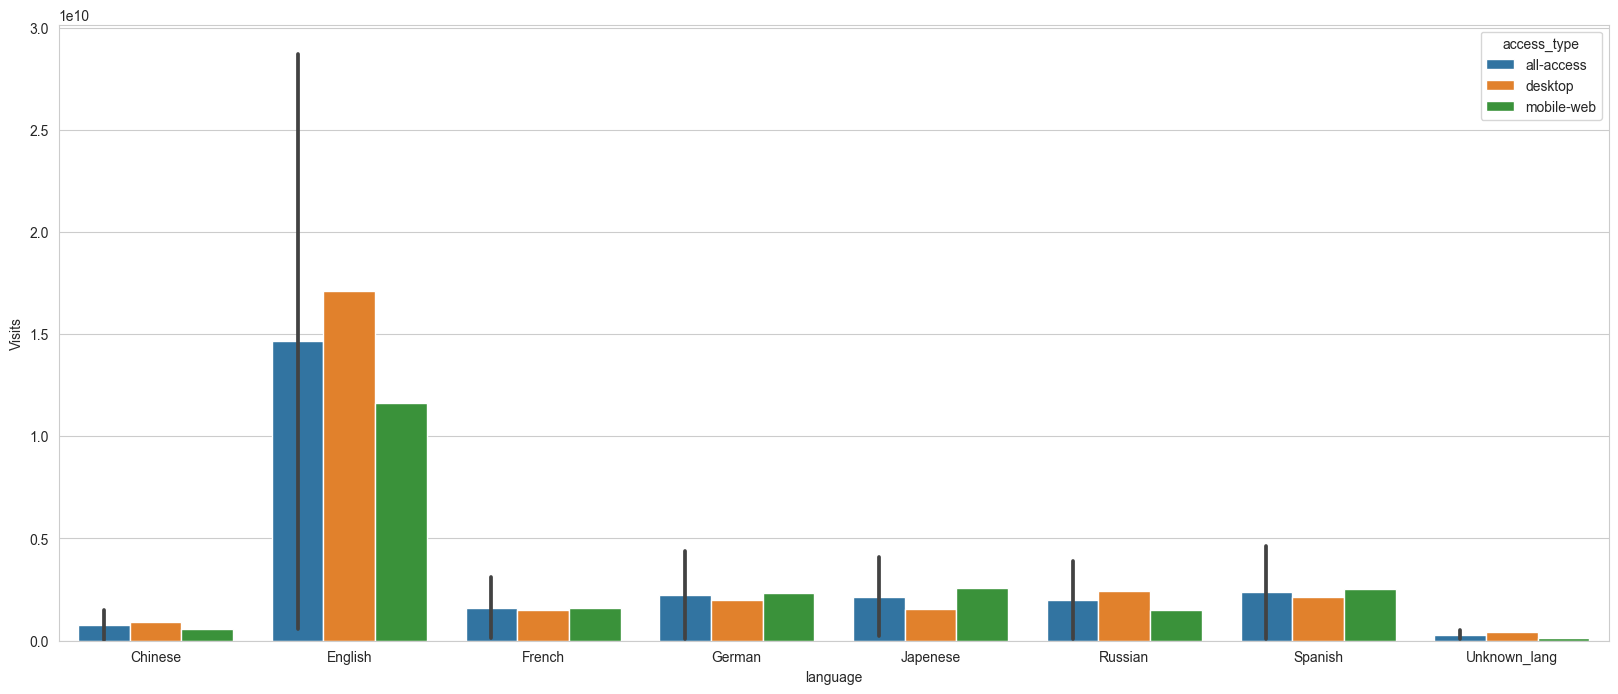

In [68]:
plt.figure(figsize=(20, 8))
sns.barplot(grouped, x="language", y="Visits", hue="access_type")

- English Language has most views in all type of access.

7. What other methods other than grid search would be suitable to get the model for all languages?

Answer:  

  In addition to grid search, methods such as Bayesian optimization using packages like hyperopt, optuna, or sci-kit-optimize can be employed.
Consider experimenting with alternative models like tsmixer or deep learning architectures to enhance the modeling process.
 